In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Path to local Kaggle CSV
CSV_PATH = "/Users/daniel/Northwestern Local/MSDS-422/Module_4_Local/data.csv"

df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head(3)

(6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474


In [7]:
# Define the target column (the outcome we want to predict)
target_col = "Bankrupt?"

# Separate the features (independent variables) from the target (dependent variable)
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Display basic information about the dataset
print("Number of records:", len(df))
print("Number of features:", X.shape[1])

# Check how many companies went bankrupt versus not bankrupt
# This helps identify whether the data are imbalanced
print("\nClass distribution:")
print(y.value_counts().to_frame().rename(columns={target_col: "count"}))

# Check for missing values across all columns
# Columns with many missing values might need imputation or removal
print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Generate basic summary statistics for numeric features
# This provides a quick sense of data ranges, central tendency, and spread
print("\nSummary statistics (first 10 features):")
display(X.describe().T.head(10))

# Identify any features with zero variance (same value for all rows)
# These features do not contribute to prediction and can be removed
desc = X.describe().T
zero_std = (desc["std"] == 0).sum()
print(f"\nNumber of features with zero variance: {zero_std}")

Number of records: 6819
Number of features: 95

Class distribution:
           count
Bankrupt?       
0           6599
1            220

Missing values (top 10):
Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 Total expense/Assets                                       0
 Total income/Total expense                                 0
 Retained Earnings to Total Assets                          0
 Long-term Liability to Current Assets                      0
 Current Liabilities/Equity                                 0
 Working Capital/Equity                                     0
 Current Liabilities/Liability                              0
 Inventory/Current Liability                                0
dtype: int64

Summary statistics (first 10 features):


,count,mean,std,min,25%,50%,75%,max
ROA(C) before interest and depreciation before interest,6819.0,0.505180,0.060686,0.0,0.476527,0.502706,0.535563,1.0
ROA(A) before interest and % after tax,6819.0,0.558625,0.065620,0.0,0.535543,0.559802,0.589157,1.0
ROA(B) before interest and depreciation after tax,6819.0,0.553589,0.061595,0.0,0.527277,0.552278,0.584105,1.0
Operating Gross Margin,6819.0,0.607948,0.016934,0.0,0.600445,0.605997,0.613914,1.0
Realized Sales Gross Margin,6819.0,0.607929,0.016916,0.0,0.600434,0.605976,0.613842,1.0
Operating Profit Rate,6819.0,0.998755,0.013010,0.0,0.998969,0.999022,0.999095,1.0
Pre-tax net Interest Rate,6819.0,0.797190,0.012869,0.0,0.797386,0.797464,0.797579,1.0
After-tax net Interest Rate,6819.0,0.809084,0.013601,0.0,0.809312,0.809375,0.809469,1.0
Non-industry income and expenditure/revenue,6819.0,0.303623,0.011163,0.0,0.303466,0.303525,0.303585,1.0
Continuous interest rate (after tax),6819.0,0.781381,0.012679,0.0,0.781567,0.781635,0.781735,1.0



Number of features with zero variance: 1


In [9]:
# ------------------------------------------------------------
# Split the data into training and validation sets (80/20)
# ------------------------------------------------------------

# Stratified sampling is used to preserve the same proportion of bankrupt vs non-bankrupt cases
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.20,         # 80% train, 20% validation
    random_state=42,        # ensures results are reproducible
    stratify=y              # keeps the class imbalance ratio consistent across both sets
)

print("Training records:", X_train.shape[0])
print("Validation records:", X_val.shape[0])
print("Training bankrupt ratio:", round(y_train.mean() * 100, 2), "%")
print("Validation bankrupt ratio:", round(y_val.mean() * 100, 2), "%")

# ------------------------------------------------------------
# Feature scaling and preprocessing
# ------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Scale all numeric features to have mean 0 and standard deviation 1
num_features = X.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_features)],
    remainder="drop"  # only numeric columns are included
)

# Confirm preprocessing pipeline is defined
print("\nPreprocessing pipeline created successfully.")

Training records: 5455
Validation records: 1364
Training bankrupt ratio: 3.23 %
Validation bankrupt ratio: 3.23 %

Preprocessing pipeline created successfully.


In [11]:
# ------------------------------------------------------------
# Define and train models: Logistic Regression, SVM, Naïve Bayes
# ------------------------------------------------------------

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Logistic Regression
# -------------------
# Common baseline model for binary classification.
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000, 
        class_weight="balanced",   # handles class imbalance by reweighting minority class
        solver="lbfgs",
        random_state=42
    ))
])

# Support Vector Machine (SVM)
# -----------------------------
# SVM finds the optimal separating boundary between classes.
# The kernel and regularization parameter (C) control model flexibility.
svm_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(
        probability=True,          # enables probability estimates for ROC/PR curves
        class_weight="balanced",   # compensates for class imbalance
        random_state=42
    ))
])

# Naïve Bayes
# ------------
# Simple probabilistic model based on Bayes’ theorem with feature independence assumptions.

nb_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", GaussianNB())
])

# ------------------------------------------------------------
# Hyperparameter tuning for SVM
# ------------------------------------------------------------

param_grid = {
    "clf__kernel": ["rbf", "linear", "poly"],   # test different kernel types
    "clf__C": [0.1, 1, 10],                     # regularization strength
    "clf__gamma": ["scale", 0.1, 0.01],         # kernel coefficient (only used for rbf/poly)
    "clf__degree": [2, 3]                       # used for polynomial kernel
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV runs cross-validation to find the best parameter combination.
# We use F1-score as the scoring metric because the data are imbalanced.
svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0
)

print("\nTraining Logistic Regression...")
log_reg.fit(X_train, y_train)

print("Training Naïve Bayes...")
nb_pipe.fit(X_train, y_train)

print("Tuning and training SVM (this may take a few minutes)...")
svm_grid.fit(X_train, y_train)
best_svm = svm_grid.best_estimator_

print("\nBest SVM parameters found:")
print(svm_grid.best_params_)


Training Logistic Regression...
Training Naïve Bayes...
Tuning and training SVM (this may take a few minutes)...

Best SVM parameters found:
{'clf__C': 0.1, 'clf__degree': 3, 'clf__gamma': 0.01, 'clf__kernel': 'poly'}


In [15]:
# ------------------------------------------------------------
# BCR (robust version) — dtype/layout checks + timed folds
# ------------------------------------------------------------
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from RegularizedRobustRegression import bcr
import numpy as np, pandas as pd, time, sys

def prep_for_bcr(X, y):
    """Scale X,y; drop zero-variance cols; return float64 C-contiguous ndarrays."""
    # Scale
    sx, sy = StandardScaler(), StandardScaler()
    Xs = pd.DataFrame(sx.fit_transform(X), columns=X.columns, index=X.index)
    ys = pd.Series(sy.fit_transform(y.values.reshape(-1,1)).ravel(), index=y.index)

    # Drop zero-variance
    keep = Xs.std(axis=0) > 1e-12
    Xs = Xs.loc[:, keep]

    # Defensive checks
    if not np.isfinite(Xs.values).all() or not np.isfinite(ys.values).all():
        badX = np.where(~np.isfinite(Xs.values))
        bady = np.where(~np.isfinite(ys.values))
        raise ValueError(f"Found non-finite values. X bad idx: {badX}, y bad idx: {bady}")

    # Cast to float64 C-contiguous for the optimizer
    X_arr = np.ascontiguousarray(Xs.values.astype(np.float64))
    y_arr = np.ascontiguousarray(ys.values.astype(np.float64))

    return X_arr, y_arr, sx, sy, Xs.columns.tolist()

def run_bcr_cv_safe(X, y, Type=2, ridge=0.6, n_splits=5, n_init=5, niter=10, seed=42):
    """
    Safer/faster BCR CV runner:
      - Ensures float64 C-order arrays
      - Prints per-fold timing so you see progress
      - Light defaults (n_init/niter) so you get results quickly
    """
    X_arr, y_arr, sx, sy, kept_cols = prep_for_bcr(X, y)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_metrics = []
    print(f"\nBCR CV start | Type={Type}  ridge={ridge}  folds={n_splits}  "
          f"inits={n_init}  iters={niter}  features={X_arr.shape[1]}")

    for fold, (tr, va) in enumerate(kf.split(X_arr), 1):
        t0 = time.time()
        Xtr, Xva = X_arr[tr], X_arr[va]
        ytr, yva = y_arr[tr], y_arr[va]

        try:
            res = bcr(ytr, Xtr, type=Type, ridge=ridge, niter=niter, n_init=n_init, seed=seed)
            beta = np.array(res["Beta"], dtype=np.float64)
            intercept, coefs = beta[0], beta[1:]
            preds = intercept + Xva.dot(coefs)

            if Type == 1:
                # Switch to DAF per professor guidance
                # DAF = 1 - sum|y-ŷ| / sum|y-ȳ|
                daf = 1 - np.sum(np.abs(yva - preds)) / np.sum(np.abs(yva - yva.mean()))
                metric_name, metric = "DAF", daf
            else:
                rmse = root_mean_squared_error(yva, preds)
                metric_name, metric = "RMSE", rmse

            fold_metrics.append(metric)
            print(f"  Fold {fold}/{n_splits}: {metric_name}={metric:.4f}  "
                  f"(elapsed {time.time()-t0:.1f}s)")
            sys.stdout.flush()

        except Exception as e:
            print(f"  Fold {fold} ERROR: {repr(e)}")
            raise

    mean_metric = float(np.mean(fold_metrics)) if fold_metrics else np.nan
    print(f"\nBCR CV done | mean {metric_name}={mean_metric:.4f}")
    return fold_metrics, mean_metric

print("Running BCR L2 (ridge=0.2) quick check...")
l2_fold_rmse, l2_mean = run_bcr_cv_safe(
    X, y, Type=2, ridge=0.2, n_splits=3, n_init=4, niter=8, seed=42
)



Running BCR L2 (ridge=0.2) quick check...

BCR CV start | Type=2  ridge=0.2  folds=3  inits=4  iters=8  features=94
  Fold 1/3: RMSE=1.1161  (elapsed 6.1s)
  Fold 2/3: RMSE=0.9365  (elapsed 6.4s)
  Fold 3/3: RMSE=1.0757  (elapsed 6.5s)

BCR CV done | mean RMSE=1.0428


In [11]:
# ------------------------------------------------------------
# L2 ridge hypertuning (uses RMSE; lower is better)
# ------------------------------------------------------------
ridge_grid_l2 = [0.05, 0.1, 0.2, 0.4, 0.8, 1.2]

l2_summary = []
print("\n--- L2 ridge tuning (RMSE) ---")
for r in ridge_grid_l2:
    print(f"\nTuning ridge={r} ...")
    _, mean_rmse = run_bcr_cv_safe(
        X, y,
        Type=2,          # L2
        ridge=r,
        n_splits=3,      # light CV so it runs quickly
        n_init=6,        # a few restarts to reduce local optima
        niter=12,        # a few iterations per restart
        seed=42
    )
    l2_summary.append((r, mean_rmse))

# Pick best ridge (min RMSE)
best_r_l2, best_rmse = min(l2_summary, key=lambda t: t[1])
print("\nL2 tuning results (ridge, mean RMSE):")
for r, m in l2_summary:
    print(f"  {r:>4}: {m:.4f}")
print(f"\nBest L2 ridge = {best_r_l2}  (mean RMSE = {best_rmse:.4f})")


--- L2 ridge tuning (RMSE) ---

Tuning ridge=0.05 ...

BCR CV start | Type=2  ridge=0.05  folds=3  inits=6  iters=12  features=94
  Fold 1/3: RMSE=0.9847  (elapsed 12.9s)
  Fold 2/3: RMSE=0.8521  (elapsed 13.2s)
  Fold 3/3: RMSE=0.9690  (elapsed 14.0s)

BCR CV done | mean RMSE=0.9352

Tuning ridge=0.1 ...

BCR CV start | Type=2  ridge=0.1  folds=3  inits=6  iters=12  features=94
  Fold 1/3: RMSE=1.0474  (elapsed 14.9s)
  Fold 2/3: RMSE=0.8712  (elapsed 14.1s)
  Fold 3/3: RMSE=0.9956  (elapsed 13.4s)

BCR CV done | mean RMSE=0.9714

Tuning ridge=0.2 ...

BCR CV start | Type=2  ridge=0.2  folds=3  inits=6  iters=12  features=94
  Fold 1/3: RMSE=1.1424  (elapsed 13.7s)
  Fold 2/3: RMSE=0.9221  (elapsed 14.1s)
  Fold 3/3: RMSE=1.0448  (elapsed 14.1s)

BCR CV done | mean RMSE=1.0364

Tuning ridge=0.4 ...

BCR CV start | Type=2  ridge=0.4  folds=3  inits=6  iters=12  features=94
  Fold 1/3: RMSE=1.4905  (elapsed 14.0s)
  Fold 2/3: RMSE=0.9380  (elapsed 14.1s)
  Fold 3/3: RMSE=1.1225  (elaps

In [17]:
# ------------------------------------------------------------
# L1-norm BCR (robust regression) hypertuning — uses DAF metric
# ------------------------------------------------------------
def deviation_accounted_for(y_true, y_pred):
    """Compute Deviation Accounted For (DAF) — used for L1-norm models."""
    return 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))


# Use smaller subset for faster testing
X_sample = X.sample(1500, random_state=42)   
y_sample = y.loc[X_sample.index]

ridge_grid_l1 = [0.02, 0.05, 0.1, 0.2]  # smaller ridge range per professor feedback
l1_summary = []

print("\n--- L1-norm ridge tuning (DAF, fast version) ---")
for r in ridge_grid_l1:
    print(f"\nTuning ridge={r} ...")
    folds = []
    
    # Preprocess data (scaling + safety checks)
    X_arr, y_arr, _, _, _ = prep_for_bcr(X_sample, y_sample)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    
    for fold, (tr, va) in enumerate(kf.split(X_arr), 1):
        t0 = time.time()
        Xtr, Xva = X_arr[tr], X_arr[va]
        ytr, yva = y_arr[tr], y_arr[va]

        try:
            # Run BCR with lighter settings to prevent long hangs
            res = bcr(ytr, Xtr, type=1, ridge=r, niter=5, n_init=2, seed=42)
            beta = np.array(res["Beta"], dtype=np.float64)
            intercept, coefs = beta[0], beta[1:]
            preds = intercept + Xva.dot(coefs)

            # Compute DAF (higher is better)
            daf = deviation_accounted_for(yva, preds)
            folds.append(daf)

            print(f"  Fold {fold}/3: DAF={daf:.4f}  (elapsed {time.time()-t0:.1f}s)")
            sys.stdout.flush()

        except Exception as e:
            print(f"  Fold {fold}/3 ERROR: {repr(e)}")
            folds.append(np.nan)

    mean_daf = np.nanmean(folds)
    l1_summary.append((r, mean_daf))
    print(f"Mean DAF for ridge={r}: {mean_daf:.4f}")

# Pick the ridge value with the highest DAF
best_r_l1, best_daf = max(l1_summary, key=lambda t: t[1])

print("\nL1 tuning results (ridge, mean DAF):")
for r, m in l1_summary:
    print(f"  {r:>4}: {m:.4f}")
print(f"\n Best L1 ridge = {best_r_l1}  (mean DAF = {best_daf:.4f})")


--- L1-norm ridge tuning (DAF, fast version) ---

Tuning ridge=0.02 ...
  Fold 1/3: DAF=-0.2437  (elapsed 10.3s)
  Fold 2/3: DAF=-0.0700  (elapsed 10.3s)
  Fold 3/3: DAF=-0.9554  (elapsed 10.2s)
Mean DAF for ridge=0.02: -0.4230

Tuning ridge=0.05 ...
  Fold 1/3: DAF=-0.8258  (elapsed 10.4s)
  Fold 2/3: DAF=-0.6607  (elapsed 10.5s)
  Fold 3/3: DAF=-2.2385  (elapsed 10.4s)
Mean DAF for ridge=0.05: -1.2417

Tuning ridge=0.1 ...
  Fold 1/3: DAF=-1.6579  (elapsed 10.4s)
  Fold 2/3: DAF=-1.3267  (elapsed 10.4s)
  Fold 3/3: DAF=-3.7995  (elapsed 10.4s)
Mean DAF for ridge=0.1: -2.2614

Tuning ridge=0.2 ...
  Fold 1/3: DAF=-2.7478  (elapsed 10.5s)
  Fold 2/3: DAF=-2.2205  (elapsed 10.6s)
  Fold 3/3: DAF=-5.5396  (elapsed 10.5s)
Mean DAF for ridge=0.2: -3.5027

L1 tuning results (ridge, mean DAF):
  0.02: -0.4230
  0.05: -1.2417
   0.1: -2.2614
   0.2: -3.5027

 Best L1 ridge = 0.02  (mean DAF = -0.4230)


In [1]:
# ============================================================
# Consolidation 
# ============================================================

import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, root_mean_squared_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from RegularizedRobustRegression import bcr

# ------------------------------------------------------------
# Load and prepare dataset
# ------------------------------------------------------------
print("Loading dataset...")
data = pd.read_csv('/Users/daniel/Northwestern Local/MSDS-422/Module_4_Local/data.csv')
X = data.drop("Bankrupt?", axis=1)
y = data["Bankrupt?"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# ------------------------------------------------------------
# Utility: compute metrics for classifiers
# ------------------------------------------------------------
def evaluate_model(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "BCR_Metric": np.nan,
        "BCR_Score": np.nan
    }

# ------------------------------------------------------------
# Train Logistic, SVM, Naïve Bayes with progress tracking
# ------------------------------------------------------------
results = []

print("\nTraining traditional models...\n")
for model_name, model in tqdm([
    ("Logistic Regression", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced",
                                   solver="lbfgs", random_state=42))
    ])),
    ("SVM", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", C=0.1, gamma=0.01, degree=3,
                    class_weight="balanced", probability=True, random_state=42))
    ])),
    ("Naïve Bayes", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB())
    ]))
], desc="Fitting models", leave=True):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    results.append(evaluate_model(y_val, preds, model_name))
    time.sleep(0.1)  # smooth tqdm refresh

# ------------------------------------------------------------
# Professor’s BCR Model
# ------------------------------------------------------------
def prep_for_bcr(X, y):
    """Standardize features and target; ensure safe float64 arrays."""
    sx, sy = StandardScaler(), StandardScaler()
    Xs = pd.DataFrame(sx.fit_transform(X), columns=X.columns)
    ys = pd.Series(sy.fit_transform(y.values.reshape(-1, 1)).ravel())
    keep = Xs.std(axis=0) > 1e-12
    X_arr = np.ascontiguousarray(Xs.loc[:, keep].values.astype(np.float64))
    y_arr = np.ascontiguousarray(ys.values.astype(np.float64))
    return X_arr, y_arr

def deviation_accounted_for(y_true, y_pred):
    """Compute Deviation Accounted For (DAF)."""
    denom = np.sum(np.abs(y_true - np.mean(y_true)))
    if denom <= 0:
        return np.nan
    return 1 - np.sum(np.abs(y_true - y_pred)) / denom

def run_bcr_inline(X, y, Type=2, ridge=0.05, n_splits=3,
                   n_init=6, niter=12, seed=42, downsample_for_L1=0):
    """
    Cross-validation for BCR (inline, no multiprocessing).
    Type=2 uses RMSE (lower is better).
    Type=1 uses DAF (higher is better).
    """
    X_arr, y_arr = prep_for_bcr(X, y)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    desc = f"BCR (Type {Type}) Progress"

    with tqdm(total=n_splits, desc=desc, leave=True) as pbar:
        for fold, (tr, va) in enumerate(kf.split(X_arr), 1):
            Xtr, Xva = X_arr[tr], X_arr[va]
            ytr, yva = y_arr[tr], y_arr[va]

            # Downsample for L1-norm (to avoid freezing)
            if Type == 1 and downsample_for_L1 and Xtr.shape[0] > downsample_for_L1:
                rng = np.random.default_rng(seed + fold)
                idx = rng.choice(Xtr.shape[0], size=downsample_for_L1, replace=False)
                Xtr = Xtr[idx]
                ytr = ytr[idx]

            t0 = time.time()
            try:
                res = bcr(ytr, Xtr, type=Type, ridge=ridge, niter=niter, n_init=n_init, seed=seed + fold)
                beta = np.array(res["Beta"], dtype=np.float64)
                intercept, coefs = beta[0], beta[1:]
                preds = intercept + Xva.dot(coefs)
                metric = deviation_accounted_for(yva, preds) if Type == 1 else root_mean_squared_error(yva, preds)
                scores.append(float(metric))
                elapsed = time.time() - t0
                print(f"  Fold {fold}/{n_splits}: metric={metric:.4f} (elapsed {elapsed:.1f}s)")
            except Exception as e:
                print(f"  Fold {fold}/{n_splits} ERROR: {repr(e)}")
                scores.append(np.nan)
            finally:
                pbar.update(1)

    return float(np.nanmean(scores)) if len(scores) else np.nan

print("\nRunning Professor's BCR Models...\n")

# L2 version (ridge = 0.05, stable)
bcr_l2_rmse = run_bcr_inline(
    X_train, y_train,
    Type=2, ridge=0.05, n_splits=3,
    n_init=6, niter=12, seed=42
)

# L1 version (ridge = 0.02, lighter settings)
bcr_l1_daf = run_bcr_inline(
    X_train, y_train,
    Type=1, ridge=0.02, n_splits=3,
    n_init=3, niter=6, seed=42,
    downsample_for_L1=3000
)

# ------------------------------------------------------------
# Compile and display results
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
results_df.loc[len(results_df)] = {
    "Model": "BCR (L2)",
    "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan,
    "BCR_Metric": "RMSE (lower is better)", "BCR_Score": bcr_l2_rmse
}
results_df.loc[len(results_df)] = {
    "Model": "BCR (L1)",
    "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan,
    "BCR_Metric": "DAF (higher is better)", "BCR_Score": bcr_l1_daf
}

print("\n=== Model Comparison Summary ===")
print(results_df.to_string(index=False))

Loading dataset...
Train shape: (5455, 95), Validation shape: (1364, 95)

Training traditional models...



Fitting models: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]



Running Professor's BCR Models...



BCR (Type 2) Progress:  33%|███████▎              | 1/3 [00:10<00:20, 10.28s/it]

  Fold 1/3: metric=0.9056 (elapsed 10.3s)


BCR (Type 2) Progress:  67%|██████████████▋       | 2/3 [00:20<00:10, 10.54s/it]

  Fold 2/3: metric=1.0452 (elapsed 10.7s)


BCR (Type 2) Progress: 100%|██████████████████████| 3/3 [00:31<00:00, 10.66s/it]


  Fold 3/3: metric=0.9033 (elapsed 11.0s)


BCR (Type 1) Progress:  33%|███████▎              | 1/3 [01:00<02:01, 60.54s/it]

  Fold 1/3: metric=-0.4036 (elapsed 60.5s)


BCR (Type 1) Progress:  67%|██████████████▋       | 2/3 [02:01<01:00, 60.63s/it]

  Fold 2/3: metric=-0.1760 (elapsed 60.7s)


BCR (Type 1) Progress: 100%|██████████████████████| 3/3 [03:01<00:00, 60.45s/it]

  Fold 3/3: metric=-0.5464 (elapsed 60.1s)

=== Model Comparison Summary ===
              Model  Accuracy  Precision   Recall       F1             BCR_Metric  BCR_Score
Logistic Regression  0.878299   0.185567 0.818182 0.302521                    NaN        NaN
                SVM  0.949413   0.318841 0.500000 0.389381                    NaN        NaN
        Naïve Bayes  0.290323   0.038000 0.863636 0.072797                    NaN        NaN
           BCR (L2)       NaN        NaN      NaN      NaN RMSE (lower is better)   0.951362
           BCR (L1)       NaN        NaN      NaN      NaN DAF (higher is better)  -0.375340


In [5]:
# ============================================================
# Professor-style BCR Ridge Sweep Take 2
# ============================================================
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from RegularizedRobustRegression import bcr

# ------------------------------------------------------------
# Data prep and helper functions
# ------------------------------------------------------------
def prep_for_bcr(X, y):
    """Scale and clean features for BCR (float64 C-order arrays)."""
    sx, sy = StandardScaler(), StandardScaler()
    Xs = pd.DataFrame(sx.fit_transform(X), columns=X.columns)
    ys = pd.Series(sy.fit_transform(y.values.reshape(-1, 1)).ravel())
    keep = Xs.std(axis=0) > 1e-12
    X_arr = np.ascontiguousarray(Xs.loc[:, keep].values.astype(np.float64))
    y_arr = np.ascontiguousarray(ys.values.astype(np.float64))
    return X_arr, y_arr

def deviation_accounted_for(y_true, y_pred):
    """Deviation Accounted For (DAF) metric for L1 models."""
    denom = np.sum(np.abs(y_true - np.mean(y_true)))
    if denom <= 0:
        return np.nan
    return 1 - np.sum(np.abs(y_true - y_pred)) / denom

def run_bcr_inline(X, y, Type=2, ridge=0.05, n_splits=3,
                   n_init=6, niter=12, seed=42, downsample_for_L1=0):
    """Run BCR with visible progress bar for each fold."""
    X_arr, y_arr = prep_for_bcr(X, y)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    scores = []
    with tqdm(total=n_splits, desc=f"BCR (Type {Type}, ridge={ridge})", leave=False) as pbar:
        for fold, (tr, va) in enumerate(kf.split(X_arr), 1):
            Xtr, Xva = X_arr[tr], X_arr[va]
            ytr, yva = y_arr[tr], y_arr[va]

            # Downsampling to prevent stalls for L1
            if Type == 1 and downsample_for_L1 and Xtr.shape[0] > downsample_for_L1:
                rng = np.random.default_rng(seed + fold)
                idx = rng.choice(Xtr.shape[0], size=downsample_for_L1, replace=False)
                Xtr, ytr = Xtr[idx], ytr[idx]

            t0 = time.time()
            try:
                res = bcr(ytr, Xtr, type=Type, ridge=ridge,
                          niter=niter, n_init=n_init, seed=seed + fold)
                beta = np.array(res["Beta"], dtype=np.float64)
                intercept, coefs = beta[0], beta[1:]
                preds = intercept + Xva.dot(coefs)
                score = deviation_accounted_for(yva, preds) if Type == 1 else root_mean_squared_error(yva, preds)
                scores.append(float(score))
            except Exception as e:
                print(f"  Fold {fold} ERROR: {repr(e)}")
                scores.append(np.nan)
            finally:
                pbar.update(1)
                elapsed = time.time() - t0
                metric_name = "DAF" if Type == 1 else "RMSE"
                print(f"  Fold {fold}/{n_splits}: {metric_name}={scores[-1]:.4f} (elapsed {elapsed:.1f}s)")
    return float(np.nanmean(scores)) if scores else np.nan

def sweep_bcr_ridge(X, y, Type=2, ridge_grid=None,
                    n_splits=3, n_init=6, niter=12,
                    seed=42, downsample_for_L1=3000):
    """Sweep through ridge values with live progress and summarize results."""
    if ridge_grid is None:
        ridge_grid = [0.02, 0.03, 0.05, 0.07, 0.1]  # smaller range per professor feedback
    results = []
    print(f"\n=== BCR Ridge Sweep (Type={Type}) ===")
    for r in tqdm(ridge_grid, desc="Ridge values", leave=True):
        score = run_bcr_inline(
            X, y,
            Type=Type,
            ridge=r,
            n_splits=n_splits,
            n_init=(3 if Type == 1 else n_init),
            niter=(6 if Type == 1 else niter),
            seed=seed,
            downsample_for_L1=(downsample_for_L1 if Type == 1 else 0)
        )
        metric_name = "DAF (↑)" if Type == 1 else "RMSE (↓)"
        print(f"  ridge={r}: {metric_name}={score:.4f}")
        results.append({"ridge": r, "score": score})
    df = pd.DataFrame(results)
    best = df.loc[df["score"].idxmax()] if Type == 1 else df.loc[df["score"].idxmin()]
    print(f"\nBest ridge={best['ridge']}  |  Mean {metric_name}={best['score']:.4f}\n")
    return df, best

# ============================================================
# Run L2 and L1 sweeps
# ============================================================
l2_df, l2_best = sweep_bcr_ridge(
    X_train, y_train,
    Type=2,
    ridge_grid=[0.02, 0.03, 0.05, 0.07, 0.1],
    n_splits=3, n_init=6, niter=12
)

l1_df, l1_best = sweep_bcr_ridge(
    X_train, y_train,
    Type=1,
    ridge_grid=[0.01, 0.02, 0.05, 0.1],
    n_splits=3, n_init=3, niter=6,
    downsample_for_L1=3000
)

print("\n=== Summary of BCR Ridge Sweeps ===")
print("L2 (RMSE lower is better):")
print(l2_df.sort_values('score').to_string(index=False))
print("\nL1 (DAF higher is better):")
print(l1_df.sort_values('score', ascending=False).to_string(index=False))


=== BCR Ridge Sweep (Type=2) ===


BCR (Type 2, ridge=0.02):  33%|██████▎            | 1/3 [00:10<00:20, 10.28s/it]

  Fold 1/3: RMSE=0.8873 (elapsed 10.3s)



BCR (Type 2, ridge=0.02):  67%|████████████▋      | 2/3 [00:20<00:10, 10.50s/it]

  Fold 2/3: RMSE=1.0440 (elapsed 10.7s)



Ridge values:  20%|██████▏                        | 1/5 [00:32<02:08, 32.21s/it]

  Fold 3/3: RMSE=0.8892 (elapsed 11.2s)
  ridge=0.02: RMSE (↓)=0.9402



BCR (Type 2, ridge=0.03):  33%|██████▎            | 1/3 [00:11<00:22, 11.07s/it]

  Fold 1/3: RMSE=0.8899 (elapsed 11.1s)



BCR (Type 2, ridge=0.03):  67%|████████████▋      | 2/3 [00:21<00:10, 10.77s/it]

  Fold 2/3: RMSE=1.0382 (elapsed 10.6s)



Ridge values:  40%|████████████▍                  | 2/5 [01:04<01:37, 32.39s/it]

  Fold 3/3: RMSE=0.8920 (elapsed 10.8s)
  ridge=0.03: RMSE (↓)=0.9400



BCR (Type 2, ridge=0.05):  33%|██████▎            | 1/3 [00:10<00:21, 10.66s/it]

  Fold 1/3: RMSE=0.9056 (elapsed 10.7s)



BCR (Type 2, ridge=0.05):  67%|████████████▋      | 2/3 [00:21<00:10, 10.47s/it]

  Fold 2/3: RMSE=1.0452 (elapsed 10.3s)



Ridge values:  60%|██████████████████▌            | 3/5 [01:36<01:03, 32.00s/it]

  Fold 3/3: RMSE=0.9033 (elapsed 10.5s)
  ridge=0.05: RMSE (↓)=0.9514



BCR (Type 2, ridge=0.07):  33%|██████▎            | 1/3 [00:10<00:20, 10.49s/it]

  Fold 1/3: RMSE=0.9293 (elapsed 10.5s)



BCR (Type 2, ridge=0.07):  67%|████████████▋      | 2/3 [00:21<00:10, 10.57s/it]

  Fold 2/3: RMSE=1.0444 (elapsed 10.6s)



Ridge values:  80%|████████████████████████▊      | 4/5 [02:08<00:32, 32.12s/it]

  Fold 3/3: RMSE=0.9115 (elapsed 11.1s)
  ridge=0.07: RMSE (↓)=0.9617



BCR (Type 2, ridge=0.1):  33%|██████▋             | 1/3 [00:11<00:22, 11.06s/it]

  Fold 1/3: RMSE=1.0015 (elapsed 11.1s)



BCR (Type 2, ridge=0.1):  67%|█████████████▎      | 2/3 [00:22<00:11, 11.03s/it]

  Fold 2/3: RMSE=1.0388 (elapsed 11.0s)



Ridge values: 100%|███████████████████████████████| 5/5 [02:41<00:00, 32.27s/it]


  Fold 3/3: RMSE=0.9236 (elapsed 10.6s)
  ridge=0.1: RMSE (↓)=0.9880

Best ridge=0.03  |  Mean RMSE (↓)=0.9400


=== BCR Ridge Sweep (Type=1) ===


BCR (Type 1, ridge=0.01):  33%|██████▎            | 1/3 [01:00<02:01, 60.82s/it]

  Fold 1/3: DAF=-0.1190 (elapsed 60.9s)



BCR (Type 1, ridge=0.01):  67%|████████████▋      | 2/3 [02:01<01:00, 60.78s/it]

  Fold 2/3: DAF=0.0305 (elapsed 60.7s)



Ridge values:  25%|███████▌                      | 1/4 [03:01<09:03, 181.30s/it]

  Fold 3/3: DAF=-0.1963 (elapsed 59.7s)
  ridge=0.01: DAF (↑)=-0.0949



BCR (Type 1, ridge=0.02):  33%|██████▎            | 1/3 [01:00<02:00, 60.40s/it]

  Fold 1/3: DAF=-0.4036 (elapsed 60.4s)



BCR (Type 1, ridge=0.02):  67%|████████████▋      | 2/3 [02:00<01:00, 60.29s/it]

  Fold 2/3: DAF=-0.1760 (elapsed 60.2s)



Ridge values:  50%|███████████████               | 2/4 [06:02<06:01, 180.97s/it]

  Fold 3/3: DAF=-0.5464 (elapsed 60.1s)
  ridge=0.02: DAF (↑)=-0.3753



BCR (Type 1, ridge=0.05):  33%|██████▎            | 1/3 [01:00<02:00, 60.49s/it]

  Fold 1/3: DAF=-1.2215 (elapsed 60.5s)



BCR (Type 1, ridge=0.05):  67%|████████████▋      | 2/3 [02:01<01:00, 60.78s/it]

  Fold 2/3: DAF=-0.8056 (elapsed 61.0s)



Ridge values:  75%|██████████████████████▌       | 3/4 [09:04<03:01, 181.56s/it]

  Fold 3/3: DAF=-1.6241 (elapsed 60.7s)
  ridge=0.05: DAF (↑)=-1.2170



BCR (Type 1, ridge=0.1):  33%|██████▋             | 1/3 [01:00<02:01, 60.97s/it]

  Fold 1/3: DAF=-2.5788 (elapsed 61.0s)



BCR (Type 1, ridge=0.1):  67%|█████████████▎      | 2/3 [02:01<01:00, 60.96s/it]

  Fold 2/3: DAF=-1.4915 (elapsed 60.9s)



Ridge values: 100%|██████████████████████████████| 4/4 [12:06<00:00, 181.74s/it]

  Fold 3/3: DAF=-2.4589 (elapsed 60.6s)
  ridge=0.1: DAF (↑)=-2.1764

Best ridge=0.01  |  Mean DAF (↑)=-0.0949


=== Summary of BCR Ridge Sweeps ===
L2 (RMSE lower is better):
 ridge    score
  0.03 0.940044
  0.02 0.940176
  0.05 0.951362
  0.07 0.961731
  0.10 0.987983

L1 (DAF higher is better):
 ridge     score
  0.01 -0.094936
  0.02 -0.375340
  0.05 -1.217049
  0.10 -2.176427



=== Training traditional models ===



Fitting models: 100%|█████████████████████████████| 3/3 [00:03<00:00,  1.09s/it]


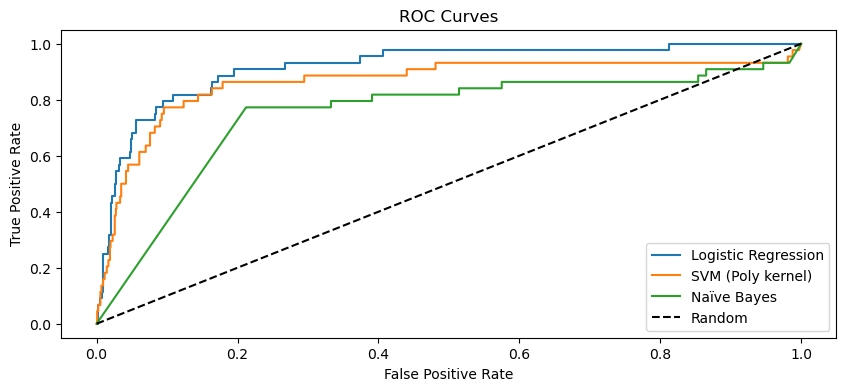

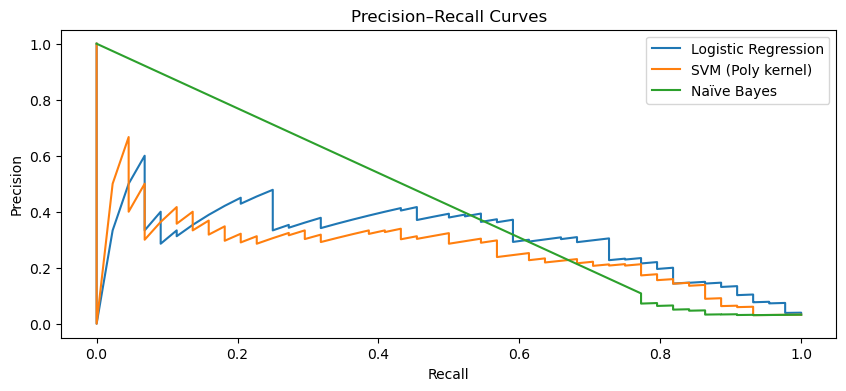


=== Model Comparison Summary ===
              Model  Accuracy  Precision   Recall        F1      TPR      FPR
Logistic Regression  0.878299   0.185567 0.818182  0.302521 0.818182 0.119697
  SVM (Poly kernel)  0.949413   0.318841 0.500000  0.389381 0.500000 0.035606
        Naïve Bayes  0.290323   0.038000 0.863636  0.072797 0.863636 0.728788
     BCR (L2, RMSE)       NaN        NaN      NaN  0.940044      NaN      NaN
      BCR (L1, DAF)       NaN        NaN      NaN -0.094936      NaN      NaN


In [7]:
# ============================================================
# Standard Models + Metrics + Graphs + Compare with BCR
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# ------------------------------------------------------------
# Utility functions
# ------------------------------------------------------------
def evaluate_model(y_true, y_pred, model_name):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "TPR": tpr,
        "FPR": fpr
    }

# ------------------------------------------------------------
# Run Logistic, SVM, Naïve Bayes
# ------------------------------------------------------------
results = []
models = [
    ("Logistic Regression", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced",
                                   solver="lbfgs", random_state=42))
    ])),
    ("SVM (Poly kernel)", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", C=0.1, gamma=0.01, degree=3,
                    class_weight="balanced", probability=True, random_state=42))
    ])),
    ("Naïve Bayes", Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB())
    ]))
]

print("\n=== Training traditional models ===\n")
for model_name, model in tqdm(models, desc="Fitting models", leave=True):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    results.append(evaluate_model(y_val, preds, model_name))

# ------------------------------------------------------------
# ROC and Precision–Recall Curves
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
for model_name, model in models:
    probs = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, probs)
    plt.plot(fpr, tpr, label=model_name)
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
for model_name, model in models:
    probs = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, probs)
    plt.plot(recall, precision, label=model_name)
plt.title("Precision–Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# ------------------------------------------------------------
# Combine Results with Professor's BCR Model
# ------------------------------------------------------------

bcr_l2_best = l2_best["score"]
bcr_l1_best = l1_best["score"]

results_df = pd.DataFrame(results)
results_df.loc[len(results_df)] = {
    "Model": "BCR (L2, RMSE)",
    "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan,
    "TPR": np.nan, "FPR": np.nan
}
results_df.loc[len(results_df)-1, "F1"] = bcr_l2_best  # just to display score in same table

results_df.loc[len(results_df)] = {
    "Model": "BCR (L1, DAF)",
    "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1": np.nan,
    "TPR": np.nan, "FPR": np.nan
}
results_df.loc[len(results_df)-1, "F1"] = bcr_l1_best

# ------------------------------------------------------------
# Display Comparison Summary
# ------------------------------------------------------------
print("\n=== Model Comparison Summary ===")
print(results_df.to_string(index=False))